##### Copyright 2025 Google LLC.

In [ ]:
# @title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Email Concierge Bot: A Function Calling Email Organizer

### What This Notebook Does:
- **Classifies Emails Using Text Embeddings:**  
  Leverages text embedding techniques to analyze email content and determine its category (e.g., deadlines, spam, meeting invites).

- **Triggers Automated Actions via Function Calling:**  
  Dynamically calls pre-defined functions (such as marking emails as important, deleting spam, or scheduling calendar events) based on the email classification.

- **Demonstrates Adaptability:**  
  Showcases how Gemini can seamlessly integrate text embedding and function calling to handle various email scenarios in a flexible, automated manner.

<a target="_blank" href="https://colab.research.google.com/github/google-gemini/cookbook/blob/main/examples/Email_Concierge_Function_Calling_Bot.ipynb"><img src="https://colab.research.google.com/assets/colab-badge.svg" height=30/>

In [ ]:
%pip install -qU "google-genai>=1.0.0"

To run this notebook, your API key must be stored it in a Colab Secret named `GOOGLE_API_KEY`. If you are running in a different environment, you can store your key in an environment variable. See [Authentication](../quickstarts/Authentication.ipynb) to learn more.

In [ ]:
from google import genai
from google.colab import userdata

client = genai.Client(api_key=userdata.get("GOOGLE_API_KEY"))

## Part I

Testing the Classifier with Mock Email Data

In this section, we simulate a real-world email environment using predefined mock emails to develop and validate the core classification logic. These emails represent common scenarios such as urgent alerts, newsletters, meeting updates, and promotions. By working with this controlled dataset first, we can safely build, test, and refine the classification pipeline—including embeddings, centroid computation, and function-based responses—before applying it to real Gmail data in Part II.


### Define the API

This smart email organizer leverages advanced text embedding techniques and dynamic function calling (see [Function Calling Notebook](https://github.com/google-gemini/cookbook/blob/main/quickstarts/Function_calling.ipynb)) to intelligently manage your email workflow. By analyzing the semantic content of your emails via [embeddings](https://github.com/google-gemini/cookbook/blob/main/quickstarts/Embeddings.ipynb) (numerical representations that convert text into vectors in a high-dimensional space, capturing not only individual words but also their contextual relationships and nuanced meanings), the bot classifies messages into categories such as "important" or "not_important". Based on these classifications, it then automatically triggers the appropriate action—whether that's prioritizing an email, flagging it for follow-up, or updating its category.

The API maintains global state through variables such as:
- **`inbox_emails`**: A list that stores incoming emails as dictionaries (with keys like `"content"` and `"category"`).
- **`category_centroids`**: A dictionary that holds normalized centroids for each predefined email category, computed from example emails in `reference_emails`.

Each function call not only updates the email status but also, once an email is processed, moves it from `inbox_emails` and triggers the necessary action. Moreover, the system can learn from corrections: when you update an email's category via the `learn_email` function, it incorporates the new example into its training data and recalculates the centroids, thereby continuously improving its classification accuracy.

Below is the complete API definition:


In [ ]:
import numpy as np
from google.genai import types
import logging
from typing import Dict, Optional, List


SIMILARITY_THRESHOLD = 0.7
EMBEDDING_MODEL_ID = "models/text-embedding-004"  # @param ["models/embedding-001", "models/text-embedding-004", "models/gemini-embedding-exp-03-07", "models/gemini-embedding-exp"] {"allow-input": true, "isTemplate": true}
inbox_emails = []

# Reference emails for centroid computation
reference_emails = {
    "important": [
        "Action required: confirm your subscription",
        "Meeting canceled: Project Alpha sync",
        "Invoice due: payment reminder for INV-123",
        "Urgent security alert for your account"
    ],
    "not_important": [
        "Weekly tech newsletter digest",
        "Summer sale: Up to 50% off!",
        "John Doe mentioned you on SocialApp",
        "Your monthly reading suggestions"
    ]
}


category_centroids = {}

def get_embedding(text: str) -> Optional[np.array]:
    """
    Fetches the embedding for the given text using the latest API call.
    Returns a NumPy array of embedding values, or None if an error occurs.

    Uses the client to call the embed_content method with task_type "retrieval_document".
    """
    if not text:
        logging.warning("Empty text provided for embedding.")
        return None

    try:
        response = client.models.embed_content(
            model=EMBEDDING_MODEL_ID,
            contents=text,
            config=types.EmbedContentConfig(
                task_type="retrieval_document"
            )
        )
        embedding_values = response.embeddings[0].values
        return np.array(embedding_values)
    except Exception as e:
        logging.error(f"Error getting embedding for text '{text[:50]}...': {e}")
        return None

def initialize_category_centroids() -> Dict[str, np.array]:
    """
    Computes the normalized centroid (mean embedding) for each predefined email category.

    For each category in reference_emails, it:
      - Computes embeddings for each example email.
      - Averages these embeddings to get a centroid.
      - Normalizes the centroid vector.

    Returns:
        A dictionary mapping category names to their normalized centroid vectors.
    """
    global category_centroids
    centroids = {}
    for category, examples in reference_emails.items():
        embeddings = [get_embedding(ex) for ex in examples]
        valid_embeddings = [emb for emb in embeddings if emb is not None]

        if not valid_embeddings:
            logging.warning(f"No valid embeddings for category '{category}'.")
            continue

        try:
            centroid = np.mean(np.vstack(valid_embeddings), axis=0)
        except Exception as e:
            logging.error(f"Error computing centroid for '{category}': {e}")
            continue

        norm = np.linalg.norm(centroid)
        if norm < 1e-6:
            logging.warning(f"Centroid norm too low for '{category}'.")
            continue

        centroids[category] = centroid / norm
        logging.info(f"Created centroid for '{category}' using {len(valid_embeddings)} examples.")

    logging.info(f"Initialized centroids for {len(centroids)} categories.")
    category_centroids = centroids
    return centroids

# Initialize centroids at startup
initialize_category_centroids()

def classify_email_using_centroids(email_body: str) -> Optional[str]:
    """
    Classifies an email by computing its embedding and comparing it against precomputed normalized centroids.

    It calculates cosine similarity (via dot product) between the normalized email embedding
    and each category centroid. If the highest similarity is greater than or equal to
    SIMILARITY_THRESHOLD, the corresponding category is returned.

    Args:
        email_body: The email content to classify.

    Returns:
        The category name (e.g., "important" or "not_important") if the similarity is high enough;
        otherwise, returns None.
    """
    global category_centroids
    if not category_centroids:
        logging.warning("No centroids available for classification.")
        return None

    email_embedding = get_embedding(email_body)
    if email_embedding is None:
        logging.info(f"Could not compute embedding for email: '{email_body[:50]}...'.")
        return None

    email_norm = np.linalg.norm(email_embedding)
    if email_norm < 1e-6:
        logging.warning(f"Email embedding norm too low for: '{email_body[:50]}...'.")
        return None

    normalized_email = email_embedding / email_norm

    similarities = {
        category: np.dot(normalized_email, centroid)
        for category, centroid in category_centroids.items()
    }
    best_category = max(similarities, key=similarities.get)
    best_similarity = similarities[best_category]

    logging.debug(f"Email: '{email_body[:30]}...' best match: '{best_category}' with similarity {best_similarity:.4f}")

    return best_category if best_similarity >= SIMILARITY_THRESHOLD else None

def add_as_important(email_content: str):
    """
    Appends the given email content to the inbox as 'important'.

    The function records the email with a category label of "important".
    """
    inbox_emails.append({"content": email_content, "category": "important"})
    logging.info("Email added as important.")

def add_as_not_important(email_content: str):
    """
    Appends the given email content to the inbox as 'not_important'.

    The function records the email with a category label of "not_important".
    """
    inbox_emails.append({"content": email_content, "category": "not_important"})
    logging.info("Email added as not important.")

def get_all_emails() -> List[Dict]:
    """
    Returns the complete list of emails currently stored in the inbox.
    Each email is expected to be a dictionary containing keys like 'content' and 'category'.
    """
    return inbox_emails

def learn_email(email_content: str, correct_category: str):
    """
    Learns from a new email example by updating our reference emails and retraining the centroids.

    Args:
        email_content: The new email text to learn from.
        correct_category: The correct category for this email (e.g., "important" or "not_important").

    Process:
        1. Adds the email to the reference_emails list for the given category.
        2. Recomputes the category centroids by calling initialize_category_centroids.
        3. Logs the learning action for future reference.
    """

    if correct_category not in reference_emails:
        reference_emails[correct_category] = []

    reference_emails[correct_category].append(email_content)
    logging.info(f"New training example added for category '{correct_category}'.")

    initialize_category_centroids()
    logging.info(f"Centroids updated after learning new email.")


### Test the API

With the functions written, test that they work as expected.

In [ ]:
important_email = "Urgent: Please review the attached report immediately"
not_important_email = "Notice: Free Subscription to newletter"


add_as_important(important_email)
add_as_not_important(not_important_email)

print("\n--- Global State ---")
print("Processed Emails:", inbox_emails)


--- Global State ---
Processed Emails: [{'content': 'Urgent: Please review the attached report immediately', 'category': 'important'}, {'content': 'Notice: Free Subscription to newletter', 'category': 'not_important'}]


### Define the prompt

Here you define the full Email Concierge bot prompt. The Email Bot automatically classifies emails using classify_email_using_centroids(email_body), marking them as important or not. If classification fails, it analyzes the email and decides manually. To find a specific email, it first retrieves all emails using get_all_emails and identifies the best match. When a user requests a category change, it updates the classification using learn_email, retrieving emails first if needed. The bot always executes actions without asking for additional input and responds with function calls or confirmation messages only.

In [ ]:
EMAIL_INSTRUCTION = """
  1. When processing an email, first call classify_email_using_centroids
  (email_body) to determine its category. If it returns 'important' or
  'not_important', immediately call add_as_important(email_content) or
  add_as_not_important(email_content) respectively.
  If no valid classification is returned, analyze the email and choose the
  appropriate function. Respond with only the function call
  (including the email content) that you are executing.
  2. Whenever a user asks for a specific email
  (e.g., 'find me the email about the assignment'), you must first call
  get_all_emails to retrieve the full list of emails. Then,
  analyze the content of these emails to locate the one that best
  matches the user's request before returning the result.
  3. If a user instructs you to change the category of an email
  (e.g., 'mark the email about the meeting as important'), you should pass the
  entire email content along with the new category to the learn_email function.
  This ensures that the system learns from the correction and updates its
  centroid-based classification accordingly or If the user's instruction
  to change an email's category does not reference a specific email,
  you should call get_all_emails to retrieve all emails, search through
  them for those that match the description provided in the request, and
  then for each matching email, pass its content along with the requested
  category to the learn_email function. In all cases, respond with a
  confirmation message without asking for additional input.
"""

### Set up the model

In this step you collate the functions into a "system" that is passed as `tools`, instantiate the model and start the chat session.

A retriable `send_message` function is also defined to help with low-quota conversations.

In [ ]:
email_tools = [
    classify_email_using_centroids,
    add_as_important,
    add_as_not_important,
    get_all_emails,
    learn_email
]

inbox_emails=[]

MODEL_ID = "gemini-2.0-flash-lite"  # @param ["gemini-2.0-flash-lite","gemini-2.0-flash","gemini-2.5-pro-exp-03-25"] {"allow-input":true, isTemplate: true}

chat = client.chats.create(
    model=MODEL_ID,
    config=types.GenerateContentConfig(
        tools=email_tools,
        system_instruction = EMAIL_INSTRUCTION
    )
)

def process_email_with_gemini(email_content: str):
    response = chat.send_message(f"""
      I am providing an email to classify using our centroid-based system.
      Email:
      {email_content}
    """)

    print(response.text)

### Dataset
This dataset represents email notifications received by a student from various university departments and organizations. Each entry in the dataset corresponds to a single email and contains the following fields:

`id`: A unique identifier for each email.

`subject`: The title or topic of the email.

`from`: The sender's email address.

`to`: The recipient's email address (the student).

`date`: The timestamp of when the email was sent (in ISO 8601 format).

`body`: The main content of the email.

The dataset includes emails related to assignments, exams, club meetings, scholarships, library notices, IT updates, career opportunities, social events, and university announcements.


---


We will import this dataset for testing purposes.

In [ ]:
import requests

url = "https://gist.githubusercontent.com/andycandy/7fc329566d9e1d6a63b6db56b2700219/raw/"

try:
    response = requests.get(url)
    response.raise_for_status()
    dummy_emails = response.json()
except Exception  as e:
    print(f"Error : {e}")

### Simulate recieving a few emails

In [ ]:
import random

sample_emails = random.sample(dummy_emails, 5)

for email in sample_emails:
    email_string = (
        f"From: {email.get('from', '')}\n"
        f"Subject: {email.get('subject', '')}\n"
        f"Body: {email.get('body', '')}"
    )
    print(email_string)
    process_email_with_gemini(email_string)


From: surveys@spampoints.com
Subject: Earn Rewards by Completing Simple Surveys
Body: Complete simple surveys and earn rewards. Sign up and start earning points today!
OK. I have added the email to the "not_important" category.

From: system@spamincome.com
Subject: Earn $1000 a Day with This System
Body: Discover our proven system to earn $1000 a day from home. Sign up now for details.
OK. I have added the email to the "not_important" category.

From: registrar@example.edu
Subject: Exam Schedule for History 101
Body: Please check the attached exam schedule for History 101. Make sure you note the timings.
OK. I have added the email to the "important" category.

From: volunteer@example.edu
Subject: Volunteer Orientation: Local Charity
Body: Join the volunteer orientation session for a local charity event. Make a difference in your community!
OK. I have added the email to the "important" category.

From: studentgov@example.edu
Subject: Student Government Election Announcement
Body: Electi

### Chat with Email Classification Learning Bot
With our email classification system defined and the Gemini chat session created, all that's left is to connect user input to the model and display the output in a loop. This interactive loop continues until you decide to exit by providing an empty input or typing "exit"/"quit".

When run in Colab or a similar environment, any fixed-width text (like prompts or print statements) originates from your Python code, while regular text comes from the Gemini API. User inputs are displayed in outlined boxes with a leading ">".

Try it out and modify the classification to directly teach the bot what to do and what not to do—update any misclassified emails by correcting their categories with your command!

In [ ]:
from IPython.display import display, Markdown

print("Welcome to Email Classification Learning Bot!")
print("Fix wrong classification of emails by updating their category with your command.")
print("Chat with bot or leave input empty to quit:\n")

while True:
    user_input = input("> ")
    if not user_input.strip() or user_input.lower() in ["exit", "quit"]:
        break
    response = chat.send_message(user_input)
    display(Markdown(response.text))

print("\n[Email Classification Learning Bot session over]")


Welcome to Email Classification Learning Bot!
Fix wrong classification of emails by updating their category with your command.
Chat with bot or leave input empty to quit:

> what mails have i got recently?


You have the following emails:

*   From: surveys@spampoints.com
    Subject: Earn Rewards by Completing Simple Surveys
    Body: Complete simple surveys and earn rewards. Sign up and start earning points today!
*   From: system@spamincome.com
    Subject: Earn $1000 a Day with This System
    Body: Discover our proven system to earn $1000 a day from home. Sign up now for details.
*   From: registrar@example.edu
    Subject: Exam Schedule for History 101
    Body: Please check the attached exam schedule for History 101. Make sure you note the timings.
*   From: volunteer@example.edu
    Subject: Volunteer Orientation: Local Charity
    Body: Join the volunteer orientation session for a local charity event. Make a difference in your community!
*   From: studentgov@example.edu
    Subject: Student Government Election Announcement
    Body: Elections for the student government are coming up. Get informed and participate in the voting process!

> Election Announcements are not important to me


OK. I have updated the system based on your feedback.


> 

[Email Classification Learning Bot session over]


Try it out and fix any misclassified emails by updating their categories with your command!

Some things to try:

* Ask for a specific email (e.g., "find me the email about the assignment")
* Use terms that are not explicitly mentioned in the prompt (e.g., "student portal mails are urgent" or "newsletter emails are not important")
* Change your mind mid-command (e.g., "uhh, cancel that, mark the email as important instead")
* Go off-script (e.g., "what are the upcoming project updates?")

In [ ]:
process_email_with_gemini("From: studentgov@example.edu\n Subject: Upcoming Student Government Elections - Your Voice Matters!\n Body: The time has come for our annual student government elections! Make sure you stay informed about the candidates and cast your vote to have a say in the future of our school. Your participation is crucial to shaping the student experience. Don't miss out—get invo")

OK. I have added the email to the "not_important" category.



## Part II

Using the Classifier on Real Emails via Gmail API

In this section, we integrate our semantic email classification system with **real Gmail data** using the [Gmail API](https://developers.google.com/gmail/api). This allows our smart assistant to not only process mock email samples but to actively fetch, classify, label, and learn from your actual inbox content in a secure and dynamic way.

By leveraging OAuth2-based authentication, the assistant gains limited access to your Gmail inbox and performs actions such as:

* Reading the content of a specified number of recent emails.
* Classifying them using the `classify_email_using_centroids()` method built in Part I.
* Applying labels like **IMPORTANT** or **UNIMPORTANT** based on the classification.
* Receiving user feedback (e.g., reclassification corrections) and using `learn_email()` to retrain itself.

This system ensures that your classification model becomes more personalized and accurate over time, adapting to your preferences in handling your own emails.


### 1. Installing Required Libraries

To interact with Gmail programmatically, we install a few Google-provided Python libraries:

In [ ]:
%pip install --upgrade -q google-api-python-client google-auth-httplib2 google-auth-oauthlib

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.2/13.2 MB 52.9 MB/s eta 0:00:00


These packages handle:

* Authentication (`google-auth`, `oauthlib`)
* HTTP requests (`httplib2`)
* Gmail API operations (`google-api-python-client`)


In [ ]:
import os
import pickle
import base64
from google.oauth2.credentials import Credentials
from google_auth_oauthlib.flow import InstalledAppFlow
from google.auth.transport.requests import Request
from googleapiclient.discovery import build
from googleapiclient.errors import HttpError
import json


### 2. Authenticating with Gmail API

To access your Gmail inbox securely, follow the [Gmail API Quickstart guide]( https://developers.google.com/workspace/gmail/api/quickstart/python) to download your `credentials.json` and place it in your working directory. The script will handle:

* Refreshing tokens automatically if `token.pickle` exists.
* Triggering a manual authentication flow (using a one-time authorization code) if it doesn’t.

This ensures secure, token-based access to your Gmail account for just the necessary scope: modifying email labels (`https://www.googleapis.com/auth/gmail.modify`).

In [ ]:
SCOPES = ['https://www.googleapis.com/auth/gmail.modify']

creds = None

if os.path.exists('token.pickle'):
    with open('token.pickle', 'rb') as token:
        creds = pickle.load(token)

if not creds or not creds.valid:
    if creds and creds.expired and creds.refresh_token:
        creds.refresh(Request())
    else:
        # Manual authentication flow
        if not os.path.exists('credentials.json'):
            print("You need to upload your credentials.json file first.")
            raise logging.exception("Credentials file not found")

        with open('credentials.json', 'r') as f:
            client_config = json.load(f)

        flow = InstalledAppFlow.from_client_config(
            client_config,
            scopes=SCOPES,
            redirect_uri='urn:ietf:wg:oauth:2.0:oob'
        )

        auth_url, _ = flow.authorization_url(prompt='consent')

        print(f"Please go to this URL to authorize access:")
        print("\n" + auth_url + "\n")

        code = input("Enter the authorization code: ")

        flow.fetch_token(code=code)
        creds = flow.credentials

        with open('token.pickle', 'wb') as token:
            pickle.dump(creds, token)

service = build('gmail', 'v1', credentials=creds)

### 3. Setting Up Gmail Labels for Classification

To enable automatic tagging of your emails, we define two labels—`IMPORTANT` and `UNIMPORTANT`—in your Gmail account. These labels help visually organize classified emails in your inbox.

The function below ensures that these labels exist and retrieves their unique Gmail-assigned IDs:

* **`create_label(service, label_name)`**
  Checks whether a label already exists. If it doesn't, it creates the label using the Gmail API and returns its ID.

```python
important_id = create_label(service, 'IMPORTANT')
unimportant_id = create_label(service, 'UNIMPORTANT')
```

These label IDs are then used in subsequent steps to apply or modify labels on emails after they are classified. This setup allows the assistant to programmatically tag each email based on its inferred importance.


In [ ]:
def create_label(service, label_name):
    """
    Creates a label in Gmail if it does not already exist.

    Args:
        service: Authenticated Gmail API service instance.
        label_name: Name of the label to create.

    Returns:
        The ID of the created or existing label.
    """
    try:
        # List existing labels
        existing_labels = service.users().labels().list(userId='me').execute()
        for label in existing_labels.get('labels', []):
            if label['name'] == label_name:
                print(f"Label '{label_name}' already exists.")
                return label['id']

        label_body = {
            'name': label_name,
            'labelListVisibility': 'labelShow',
            'messageListVisibility': 'show'
        }
        created_label = service.users().labels().create(userId='me', body=label_body).execute()
        print(f"Label '{label_name}' created successfully.")
        return created_label['id']

    except HttpError as error:
        print(f"An error occurred while creating the label '{label_name}': {error}")
        return None


important_id = create_label(service, 'IMPORTANT')
unimportant_id = create_label(service, 'UNIMPORTANT')



### 4. Gmail Integration Functions

Several helper functions are defined to support seamless Gmail operations:


* **`label_as_important(email_id)`** and **`label_as_unimportant(email_id)`**: Programmatically modify the labels of Gmail messages based on classification outcomes.
* **`get_emails(num_emails)`**: Retrieves a user-specified number of recent emails from Gmail, extracts their content, and structures them for classification.

These allow our system to act on real emails exactly as it did with the mock data in Part I, but now in a live production environment.

In [ ]:
def label_as_important(email_id: str):
    """
    Marks the specified email as important using Gmail API.

    Args:
        email_id: The ID of the email to mark as important
    """
    try:
        # Add IMPORTANT label and remove UNIMPORTANT if present
        service.users().messages().modify(
            userId='me',
            id=email_id,
            body={
                'addLabelIds': [important_id],
                'removeLabelIds': [unimportant_id]
            }
        ).execute()
        logging.info(f"Email {email_id} marked as important.")
        return True
    except HttpError as error:
        logging.error(f"Error marking email as important: {error}")
        return False

def label_as_unimportant(email_id: str):
    """
    Marks the specified email as not important using Gmail API.

    Args:
        email_id: The ID of the email to mark as not important
    """
    try:
        service.users().messages().modify(
            userId='me',
            id=email_id,
            body={
                'addLabelIds': [unimportant_id],
                'removeLabelIds': [important_id]
            }
        ).execute()
        logging.info(f"Email {email_id} marked as not important.")
        return True
    except HttpError as error:
        logging.error(f"Error marking email as not important: {error}")
        return False

def get_emails(num_emails: int) -> List[str]:
    """
    Returns a specified number of recent emails from Gmail with their content and category.

    Args:
        num_emails: The exact number of emails to retrieve

    Returns:
        List of strings containing email content and category
    """
    try:
        # Get messages
        response = service.users().messages().list(
            userId='me',
            maxResults=num_emails
        ).execute()

        messages = []
        if 'messages' in response:
            message_ids = response['messages']

            for msg in message_ids:
                message = service.users().messages().get(
                    userId='me',
                    id=msg['id'],
                    format='full'
                ).execute()

                payload = message.get('payload', {})
                parts = payload.get('parts', [])

                content = ""
                if parts:
                    for part in parts:
                        if part.get('mimeType') == 'text/plain':
                            body_data = part.get('body', {}).get('data', '')
                            if body_data:
                                import base64
                                content = base64.urlsafe_b64decode(body_data).decode('utf-8')
                                break

                if not content and 'body' in payload and 'data' in payload['body']:
                    import base64
                    content = base64.urlsafe_b64decode(payload['body']['data']).decode('utf-8')

                labels = message.get('labelIds', [])

                headers = {header['name']: header['value']
                          for header in payload.get('headers', [])}

                messages.append(f"""
                    id : {msg['id']},
                    content : {content},
                    subject : {headers.get('Subject', 'No Subject')},
                    from : {headers.get('From', 'Unknown Sender')},
                    labels : {labels}
                """)

        return messages
    except HttpError as error:
        logging.error(f"Error retrieving emails: {error}")
        return []


def learn_email(email_content: str, correct_category: str):
    """
    Learns from a new email example by updating our reference emails and retraining the centroids.

    Args:
        email_content: The new email text to learn from.
        correct_category: The correct category for this email (e.g., "important" or "unimportant").

    Process:
        1. Adds the email to the reference_emails list for the given category.
        2. Recomputes the category centroids by calling initialize_category_centroids.
        3. Logs the learning action for future reference.
    """

    if correct_category not in reference_emails:
        reference_emails[correct_category] = []

    reference_emails[correct_category].append(email_content)
    logging.info(f"New training example added for category '{correct_category}'.")

    initialize_category_centroids()
    logging.info(f"Centroids updated after learning new email.")

### 5. Classifying Emails and Learning from Feedback

Once emails are fetched from Gmail, they are passed through the **same centroid-based classification system** introduced in Part I. The assistant determines each email’s category based on its semantic similarity to known examples:

* If the classifier confidently identifies the category (e.g., "important" or "unimportant"), the corresponding Gmail label is applied using `label_as_important()` or `label_as_unimportant()`.
* If the similarity is below the threshold or ambiguous, the assistant falls back on manual analysis of the content to make a judgment.

This hybrid approach—blending automated classification with natural language reasoning—mimics how a human assistant might operate when faced with uncertainty.

To further improve over time, the assistant actively **learns from user feedback**. When you correct a classification, the `learn_email()` function is triggered. It:

* Adds the corrected email to the appropriate category’s reference set.
* Recomputes the centroid vectors using the updated examples.

Additionally, if you provide a general instruction like *"all emails about club meetings are not important"*, the assistant:

* Generates a representative template email based on the scenario.
* Uses it to retrain the model via `learn_email()`.

This feedback loop allows the system to adapt to your evolving preferences and handle even nuanced or domain-specific email types with increasing accuracy.


In [ ]:
EMAIL_ASSISTANT_PROMPT = """
  Here are the steps for performing specific tasks
  1. Fetch Emails: I will start by retrieving emails using the `get_emails`
  function.
  2. Classify Emails:
  Use the `classify_email_using_centroids` function to check the
  category of each email. If the function returns a category like
  "important" or "unimportant", use that label.
  If the function returns None, read the email content yourself
  and decide the correct label.
  Based on the label (either from the function or your analysis), call:
  label_as_important(email) if it's important
  label_as_unimportant(email) if it's not important
  3. User Feedback and Learning:
  If you tell me an email is wrongly labeled, I will correct the label
  using the appropriate function (label_as_important or label_as_unimportant).
  I will then use the learn_email function to learn from the
  mislabeled email and the correct label, improving future classifications.
  4.Handling Template Emails: When you ask me to categorize emails based on
  a specific scenario (e.g., "college party emails are not important"),
  I will:
  Generate a template email reflecting the scenario.
  Then I will use the `learn_email` function to teach the
  system about that email with correct label.

"""


### 6. Deploying the Enhanced Assistant

We instantiate a Gemini-powered chat session with function calling support:

```python
functions_dict = [
    classify_email_using_centroids,
    label_as_important,
    label_as_unimportant,
    get_emails,
    learn_email
]
```

This list is passed to Gemini as available tools. A loop reads user prompts, determines whether a function call is needed, executes the function, and adds the response to the conversation history.

The chat interface is enhanced to:

* Detect when Gemini requests a function.
* Route the call to the right Python method.
* Return the result back to Gemini for further response generation.


In [ ]:
from google.genai import types

MODEL_ID = "gemini-2.0-flash-lite"  # @param ["gemini-2.0-flash-lite","gemini-2.0-flash","gemini-2.5-pro-exp-03-25"] {"allow-input":true, isTemplate: true}

functions_dict = [
    classify_email_using_centroids,
    label_as_important,
    label_as_unimportant,
    get_emails,
    learn_email
]



### 8. Chat Session in Action

Once the loop is initiated, you can interact with the assistant like a personal email manager:

* Ask it to read and label your recent emails.
* Tell it which ones are wrongly labeled.
* Teach it custom rules and examples to follow.
* Watch it improve over time with continued feedback.

All conversations are dynamically updated via the Gemini API using `generate_content`, and relevant actions are logged and reflected in your Gmail inbox.


In [ ]:
def call_function(function_call):
    function_name = function_call.name
    function_args = function_call.args
    print("trying to run", function_call)
    for func in functions_dict:
        if func.__name__ == function_name:
            return func(**function_args)
    raise ValueError(f"Function {function_name} not found in tools.")

def chat_loop():
    while True:
        response = client.models.generate_content(
            model=MODEL_ID,
            contents=messages,
            config={
                "tools": functions_dict,
                "system_instruction": EMAIL_ASSISTANT_PROMPT,
            }
        )
        candidate = response.candidates[0]
        part = candidate.content.parts[0]
        if part.function_call:
            try:
                result = call_function(part.function_call)
            except ValueError as e:
                return str(e)

            model_message = types.Content(role="model", parts=[part] )
            messages.append(model_message)

            function_response_part = {
                "function_response": {
                    "response":{"output":result},
                    "name":part.function_call.name
                }
            }
            user_message = genai.types.Content(
                role="user",
                parts=[function_response_part]
            )
            messages.append(user_message)
        else:
            return response.text

In [ ]:
from IPython.display import display, Markdown

print("Welcome to Email Classification Learning Bot!")
print("Fix wrong classification of emails by updating their category with your command.")
print("Chat with bot or leave input empty to quit:\n")

messages=[]
while True:
    user_input = input("> ")
    if not user_input.strip() or user_input.lower() in ["exit", "quit"]:
        break
    messages.append(
        genai.types.Content(role="user", parts=[genai.types.Part(text=user_input)]),
    )
    proper_response=chat_loop()
    display(Markdown(proper_response))

print("\n[Email Classification Learning Bot session over]")


Welcome to Email Classification Learning Bot!
Fix wrong classification of emails by updating their category with your command.
Chat with bot or leave input empty to quit:

> get my last 3 emails and classify them accordingly


OK. The first two emails are classified as "important", and the last one as "unimportant".


> 

[Email Classification Learning Bot session over]


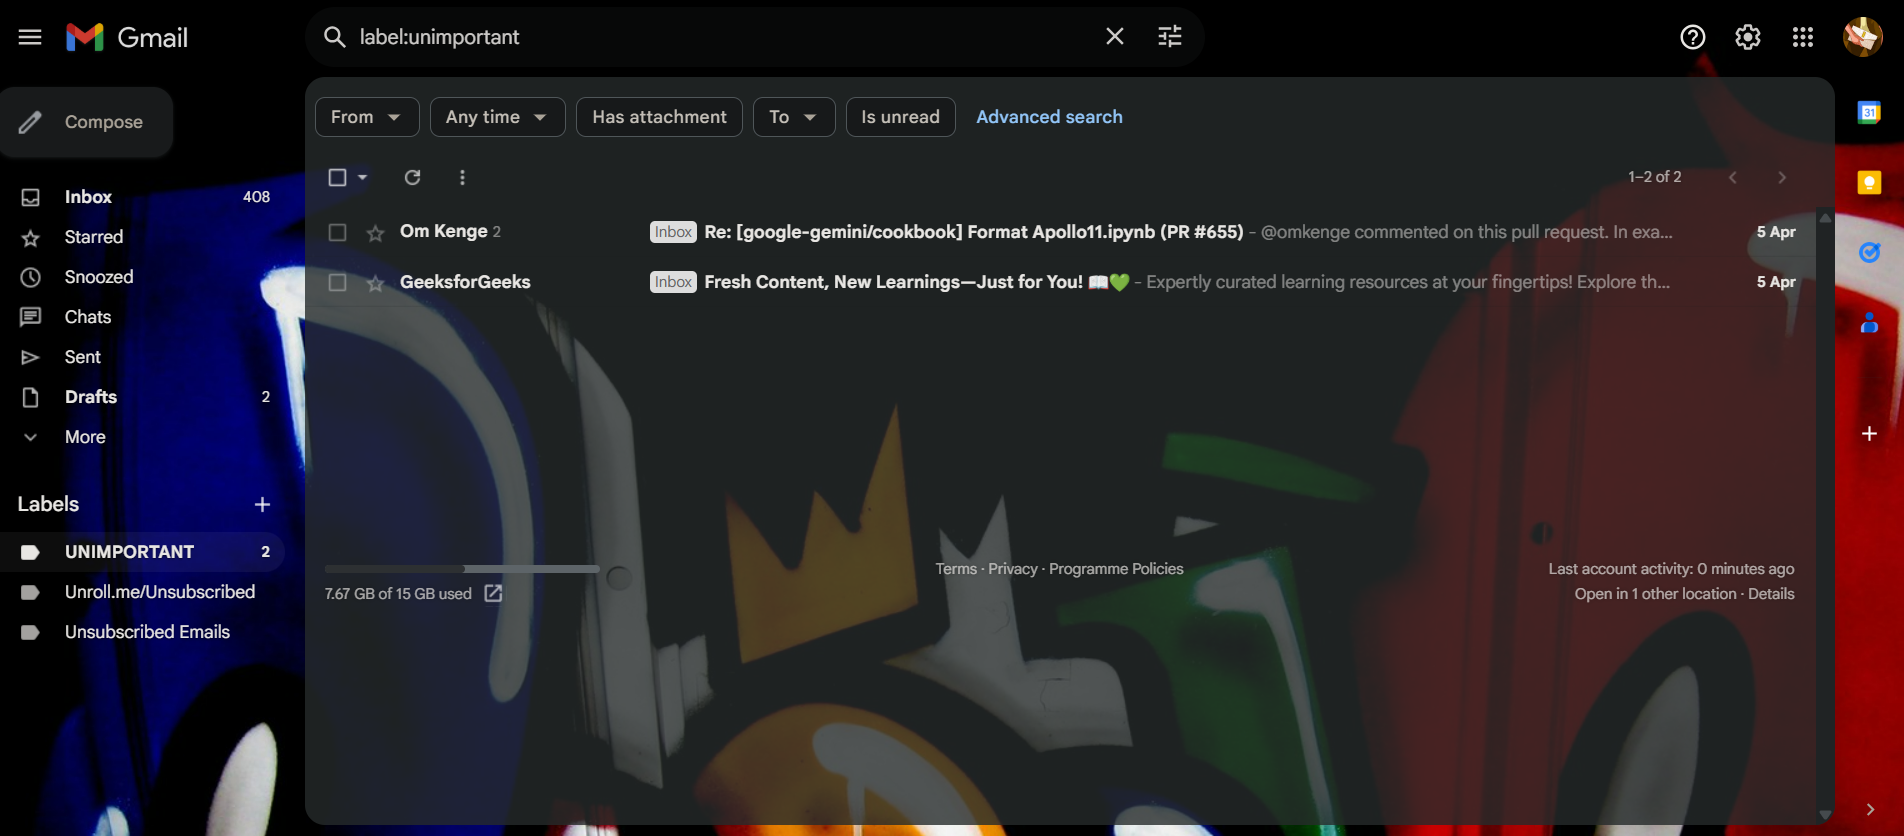

It worked!

## See also

This sample app showed you how to integrate a traditional software system (the coffee ordering functions) and an AI agent powered by the Gemini API. This is a simple, practical way to use LLMs that allows for open-ended human language input and output that feels natural, but still keeps a human in the loop to ensure correct operation.

To learn more about how Barista Bot works, check out:

* The [Barista Bot](https://aistudio.google.com/app/prompts/barista-bot) prompt
* [System instructions](../quickstarts/System_instructions.ipynb)
* [Automatic function calling](../quickstarts/Function_calling.ipynb)
